In [2]:
# Step 1: Install necessary packages
!pip install pinecone-client langchain langchain-google-genai langchain-community

# Step 2: Import necessary libraries
import os
import time
from langchain.schema import Document
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from pinecone import Pinecone
from pinecone import ServerlessSpec
from langchain.vectorstores import Pinecone as LangchainPinecone
from langchain_community.document_loaders.csv_loader import CSVLoader

# Step 3: Set up your environment variables (replace these with your actual keys)
os.environ["GOOGLE_API_KEY"] = os.environ.get("GOOGLE_API_KEY")  # replace with your Google API key
# os.environ["PINECONE_API_KEY"] = "PINECONE_API_KEY"  # replace with your Pinecone API key
# os.environ["PINECONE_CLOUD"] = "aws"
# os.environ["PINECONE_REGION"] = "us-east-1"

# Step 4: Define embedding model and initialize embeddings
# model_name = "models/embedding-001"
hf_embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

# Step 5: Configure Pinecone client
api_key = os.environ.get("PINECONE_API_KEY")
cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'

spec = ServerlessSpec(cloud=cloud, region=region)
pc = Pinecone(api_key=api_key)

# Step 6: Initialize Pinecone index
index_name = 'book-keeping-index'

# Create index if not exists
try:
    pc.create_index(index_name, dimension=768, metric='dotproduct', spec=spec)
except Exception as e:
    print(f"Index {index_name} already exists: {e}")

# Wait for index to be ready
while not pc.describe_index(index_name).status['ready']:
    time.sleep(1)

index = pc.Index(index_name)

# Step 7: Define functions for interacting with Pinecone
def initialize_pinecone(splits=None):
    """Initialize or load the Pinecone vectorstore."""
    if splits:
        print("Initializing Pinecone with new documents...")
        # Convert documents into Pinecone format and upsert
        documents = [
            {
                "id": doc.metadata.get("file_name"),  # Use file name as ID
                "values": hf_embeddings.embed_query(doc.page_content),  # Embedding
                "metadata": doc.metadata  # Metadata
            }
            for doc in splits
        ]
        index.upsert(vectors=documents)
    else:
        print("No documents to initialize.")
    return LangchainPinecone(index, hf_embeddings.embed_query, "text")

# Step 8: Load CSV data for testing
def extract_text_from_csv(file_path):
    """Extract text from a CSV file."""
    loader = CSVLoader(file_path=file_path)
    return loader.load()

# Step 9: Testing - Initialize Pinecone and Push Data
documents = []
test_text = "This is a test document for the Pinecone integration."
metadata = {"file_name": "test_file.csv", "user_id": "user_1"}

# Create a document with test data
document = Document(page_content=test_text, metadata=metadata)
documents.append(document)

# Initialize Pinecone with new documents
vectorstore = initialize_pinecone(splits=documents)

# Step 10: Fetch the documents from Pinecone
def fetch_files_in_vector_db(user_id, top_k: int = 5):
    """Fetch file names from Pinecone associated with the user."""
    query = {
        "vector": hf_embeddings.embed_query("Example search query"),  # Example query to retrieve similar vectors
        "top_k": top_k,
        "filter": {"user_id": user_id}  # Query to filter by user_id
    }  # Query to filter by user_id
    response = index.query(query)
    return [item['metadata']['file_name'] for item in response['matches']]

# Test the fetch function
file_names = fetch_files_in_vector_db(user_id="user_1", top_k=5)
print(f"Files in vector store for user_1: {file_names}")

# Step 11: Delete a document from Pinecone
def delete_vectors_from_pinecone(file_name, user_id):
    """Delete vectors associated with a specific file and user from Pinecone."""
    query = {"metadata": {"file_name": file_name, "user_id": user_id}}
    response = index.query(query)
    document_ids_to_delete = [item['id'] for item in response['matches']]
    
    if document_ids_to_delete:
        index.delete(ids=document_ids_to_delete)
        print(f"Deleted vectors for {file_name} and user {user_id}.")
    else:
        print(f"No vectors found for {file_name} and user {user_id}.")

# Test the delete function
delete_vectors_from_pinecone(file_name="test_file.csv", user_id="user_1")

# Step 12: Verify if the file is deleted
file_names_after_delete = fetch_files_in_vector_db(user_id="user_1")
print(f"Files in vector store for user_1 after deletion: {file_names_after_delete}")


e:\mathew\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Index book-keeping-index already exists: (409)
Reason: Conflict
HTTP response headers: HTTPHeaderDict({'content-type': 'text/plain; charset=utf-8', 'access-control-allow-origin': '*', 'vary': 'origin,access-control-request-method,access-control-request-headers', 'access-control-expose-headers': '*', 'x-pinecone-api-version': '2024-07', 'X-Cloud-Trace-Context': '22c34e5fdce70694b3b1c16947329b4a', 'Date': 'Mon, 06 Jan 2025 21:15:13 GMT', 'Server': 'Google Frontend', 'Content-Length': '85', 'Via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000'})
HTTP response body: {"error":{"code":"ALREADY_EXISTS","message":"Resource  already exists"},"status":409}

Initializing Pinecone with new documents...


C:\Users\OS\AppData\Local\Temp\ipykernel_10248\262645800.py:64: LangChainDeprecationWarning: The class `Pinecone` was deprecated in LangChain 0.0.18 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-pinecone package and should be used instead. To use it run `pip install -U :class:`~langchain-pinecone` and import as `from :class:`~langchain_pinecone import Pinecone``.
  return LangchainPinecone(index, hf_embeddings.embed_query, "text")
e:\mathew\venv\lib\site-packages\langchain_community\vectorstores\pinecone.py:68: UserWarning: Passing in `embedding` as a Callable is deprecated. Please pass in an Embeddings object instead.
  warnings.warn(


TypeError: query() missing 1 required keyword-only argument: 'top_k'

In [7]:
# Step 2: Import necessary libraries
import os
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from pinecone import Pinecone, ServerlessSpec
# from langchain_pinecone import PineconeVectorStore

# Step 3: Set up your environment variables
# Replace the placeholders with your actual API keys and Pinecone environment
os.environ["GOOGLE_API_KEY"] = os.environ.get("GOOGLE_API_KEY") 


# Step 5: Configure Pinecone client
api_key = os.environ.get("PINECONE_API_KEY")
pinecone_api_key = os.environ.get("PINECONE_API_KEY")

pc = Pinecone(api_key=pinecone_api_key)

# Step 4: Initialize the embedding model
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

index_name = "book-keeping-index"  # change if desired

existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]

if index_name not in existing_indexes:
    pc.create_index(
        name=index_name,
        dimension=768,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )
    while not pc.describe_index(index_name).status["ready"]:
        time.sleep(1)

index = pc.Index(index_name)

# Optional: Verify initialization by printing vector store details
print(f"Pinecone vector store '{index_name}' initialized successfully.")
print(index)

e:\mathew\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Pinecone vector store 'book-keeping-index' initialized successfully.


In [ ]:
# Step 1: Import necessary libraries for PDF extraction and Pinecone integration
# import fitz  # PyMuPDF for PDF extraction
from langchain_community.document_loaders import PyPDFLoader
import os

# Assuming embeddings and vector_store are initialized as described in the previous step
# Step 2: Define a function to extract text from a PDF file
def extract_text_from_pdf(pdf_path):
    """
    Extract text from a PDF file using PyMuPDF (fitz).
    
    Args:
        pdf_path (str): Path to the PDF file.
    
    Returns:
        str: Extracted text from the PDF.
    """

    loader = PyPDFLoader(pdf_path)
    # Step 2: Load the document
    documents = loader.load()
    text = documents
    text = ""
    # # Open the PDF file
    # with fitz.open(pdf_path) as doc:
    #     # Iterate through each page and extract text
    #     for page_num in range(len(doc)):
    #         page = doc.load_page(page_num)
    #         text += page.get_text("text")
    return text

# Step 3: Add PDF to Pinecone index
def add_pdf_to_pinecone(pdf_path, user_id, index_name='book-keeping-index'):
    """
    Extracts text from the PDF, embeds it, and upserts it to the Pinecone index.
    
    Args:
        pdf_path (str): Path to the PDF file.
        user_id (str): The user ID associated with the document for filtering purposes.
        index_name (str): The Pinecone index name (default: 'book-keeping-index').
    """
    # Extract text from the PDF
    pdf_text = extract_text_from_pdf(pdf_path)
    
    # Create a document from the extracted text
    document = Document(page_content=pdf_text, metadata={"user_id": user_id, "file_name": os.path.basename(pdf_path)})
    
    # Convert document text into embedding using the predefined embedding model
    embedded_values = embeddings.embed_query(document.page_content)
    
    # Prepare the data to upsert to Pinecone (id, values, and metadata)
    document_data = [{
        "id": document.metadata["file_name"],  # Using file name as ID
        "values": embedded_values,  # Embedding of the document content
        "metadata": document.metadata  # Metadata associated with the document
    }]
    
    # Upsert the document into the Pinecone index
    index.upsert(vectors=document_data)
    print(f"Successfully added PDF {pdf_path} to Pinecone index.")

# Step 4: Test the function with a sample PDF
pdf_path = "dummy_data.pdf"  # Replace with the actual path to your PDF
user_id = "user_1"  # Example user_id
add_pdf_to_pinecone(pdf_path, user_id)

Successfully added PDF dummy_data.pdf to Pinecone index.


In [8]:
from langchain.vectorstores import Pinecone
# Step 8: Connect to the Pinecone index
index = pc.Index(index_name)

from langchain_pinecone import PineconeVectorStore

vector_store = PineconeVectorStore(index=index, embedding=embeddings)

In [1]:
import psycopg
conn = psycopg.connect("dbname=test user=postgres password=secret host=localhost")
print("Connection successful!")


ModuleNotFoundError: No module named 'psycopg'

In [2]:
import os

In [3]:
os.environ["GOOGLE_API_KEY"] = os.environ.get("GOOGLE_API_KEY") 

In [1]:
# print(os.environ.get("GOOGLE_API_KEY"))

In [2]:
# print(os.environ.get("PINECONE_API_KEY"))

In [7]:
from pinecone import Pinecone

pinecone_api_key = os.environ.get("PINECONE_API_KEY")

pc = Pinecone(api_key=pinecone_api_key)

In [3]:
# print(os.getenv("PINECONE_API_KEY"))

# print all content of pinecone

In [2]:
from langchain_pinecone import PineconeVectorStore
import os
from langchain_google_genai import GoogleGenerativeAIEmbeddings

from dotenv import load_dotenv
load_dotenv()

os.environ["PINECONE_API_KEY"] = os.getenv("PINECONE_API_KEY")

os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY") #  os.environ.get("GOOGLE_API_KEY")

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

index_name = "book-keeping-index"

vector_store = PineconeVectorStore(index=index_name, embedding=embeddings)



In [10]:
from pinecone import Pinecone

pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))

# To get the unique host for an index, 
# see https://docs.pinecone.io/guides/data/target-an-index
index = pc.Index(host=index_name)

index.fetch(["book-keeping.pdf"])

MaxRetryError: HTTPSConnectionPool(host='book-keeping-index', port=443): Max retries exceeded with url: /vectors/fetch?ids=book-keeping.pdf (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000023799DAD6D0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [9]:
# Document IDs from your search results
ids_to_fetch = ["book-keeping.pdf"]


# Fetch documents by their IDs without using the keyword argument
documents = vector_store.get_by_ids(ids_to_fetch)

NotImplementedError: PineconeVectorStore does not yet support get_by_ids.

# print data from mongodb 

In [7]:
from pymongo import MongoClient

# MongoDB connection URI
MONGO_URI = os.environ.get("MONGODB_URI")

# Connect to the MongoDB cluster
client = MongoClient(MONGODB_URI)

# List all databases
databases = client.list_database_names()
print("Databases:")
for db_name in databases:
    print(db_name)


Databases:
test
admin
local


In [8]:
from pymongo import MongoClient

# MongoDB connection URI
MONGO_URI = os.environ.get("MONGODB_URI")


# Connect to the MongoDB cluster
client = MongoClient(MONGODB_URI)

# Access the database (replace "your_database_name" with the actual name)
db = client["test"]

# List all collections in the database
collections = db.list_collection_names()

# Loop through each collection and retrieve its data
for collection_name in collections:
    collection = db[collection_name]
    documents = collection.find()  # Retrieve all documents in the collection

    print(f"Data from collection: {collection_name}")
    for doc in documents:
        print(doc)


Data from collection: users
{'_id': ObjectId('6724a7ae270a38bc33cbcf2e'), 'firstName': 'Arslan', 'lastName': 'Ahmed', 'email': 'arslan1@gmail.com', 'password': '$2b$10$DXxsIHzoAhD.wRym06iQHuLmE8KcdMxPHzrSwgRwCylzdcFkYzk6i', 'businessName': 'Azhan Soft', 'country': 'US', 'address': 'Street 123, SF', 'phone': '+18888675356', 'city': 'San Franciso', 'state': 'CA', 'zip': '94111', 'industry': 'Software Development', 'status': True, 'isDeleted': False, 'businessType': ObjectId('660efcf7a0c0f87c546fbbf3'), 'quilttId': 'p_12y7t0YIGEpatgoDUsw6uS', 'createdAt': datetime.datetime(2024, 11, 1, 10, 4, 31, 17000), 'updatedAt': datetime.datetime(2024, 11, 1, 10, 4, 31, 17000), '__v': 0}
{'_id': ObjectId('673ba93b3608c9c553176e88'), 'firstName': 'Matt', 'lastName': 'Stratman', 'email': 'mattstratman@gmail.com', 'password': '$2b$10$/nrO9/FgT6b5JfusV.DvUefJLvqirBroGYSesnIXD5lT8jKkA5pqS', 'businessName': 'abc', 'country': 'US', 'address': '123', 'phone': '+18057484095', 'city': 'los angeles', 'state': '

In [9]:
from pymongo import MongoClient

# MongoDB connection URI
MONGO_URI = os.environ.get("MONGODB_URI")

# Connect to the MongoDB cluster
client = MongoClient(MONGODB_URI)

# Access the database (replace "your_database_name" with the actual name)
db = client["admin"]

# List all collections in the database
collections = db.list_collection_names()

# Loop through each collection and retrieve its data
for collection_name in collections:
    collection = db[collection_name]
    documents = collection.find()  # Retrieve all documents in the collection

    print(f"Data from collection: {collection_name}")
    for doc in documents:
        print(doc)


In [11]:
from pymongo import MongoClient

# MongoDB connection URI
MONGO_URI = os.environ.get("MONGODB_URI")


# Connect to the MongoDB cluster
client = MongoClient(MONGODB_URI)

# Access the database (replace "your_database_name" with the actual name)
local_db = client["local"]

oplog = local_db["oplog.rs"]

oplog_entries = oplog.find()

print("Oplog Entries:")
for entry in oplog_entries:
    print(entry)

# List all collections in the database
collections = db.list_collection_names()

# Loop through each collection and retrieve its data
for collection_name in collections:
    collection = db[collection_name]
    documents = collection.find()  # Retrieve all documents in the collection

    print(f"Data from collection: {collection_name}")
    for doc in documents:
        print(doc)


Oplog Entries:
Data from collection: oplog.rs


In [12]:
from pymongo import MongoClient

# MongoDB connection URI
MONGO_URI = os.environ.get("MONGODB_URI")


# Connect to MongoDB
client = MongoClient(MONGODB_URI)
db = client["test"]

# List all collections
collections = db.list_collection_names()
print("Collections in 'test':", collections)


Collections in 'test': ['users', 'customers', 'merchants', 'merchantusers', 'usercategories', 'transactions', 'accounts', 'businesstypes', 'invoices', 'expensecategories']


In [1]:
from pymongo import MongoClient

# MongoDB connection URI
MONGO_URI = os.environ.get("MONGODB_URI")


# Connect to MongoDB
client = MongoClient(MONGODB_URI)

# Access the 'test' database
db = client["test"]

# Access the 'users' collection
users_collection = db["expensecategories"]

# Fetch all user documents
users = users_collection.find()

print("Users Data:")
for user in users:
    print(user)


Users Data:
{'_id': ObjectId('660f00b66ec1fc744d2fad13'), 'title': 'Advertising', 'status': True, 'businessType': [ObjectId('660efcf7a0c0f87c546fbbf3'), ObjectId('668b7d74c2110e89bd46f63c'), ObjectId('668b7daac2110e89bd46f642'), ObjectId('668b7db3c2110e89bd46f644')], 'createdAt': datetime.datetime(2024, 4, 4, 19, 34, 14, 379000), 'updatedAt': datetime.datetime(2024, 9, 11, 5, 39, 30, 486000), '__v': 0}
{'_id': ObjectId('66e129524df22ef70f2e90be'), 'title': 'Car and Truck Expenses', 'status': True, 'businessType': [ObjectId('660efcf7a0c0f87c546fbbf3'), ObjectId('668b7d74c2110e89bd46f63c')], 'createdAt': datetime.datetime(2024, 9, 11, 5, 23, 30, 202000), 'updatedAt': datetime.datetime(2024, 9, 11, 6, 24, 1, 267000), '__v': 0}
{'_id': ObjectId('66e129614df22ef70f2e90c1'), 'title': 'Commissions and Fees', 'status': True, 'businessType': [ObjectId('660efcf7a0c0f87c546fbbf3'), ObjectId('668b7d74c2110e89bd46f63c')], 'createdAt': datetime.datetime(2024, 9, 11, 5, 23, 45, 394000), 'updatedAt': 

In [15]:
from pymongo import MongoClient

# MongoDB connection URI
MONGO_URI = os.environ.get("MONGODB_URI")

# Connect to MongoDB
client = MongoClient(MONGODB_URI)

# Access the 'test' database
db = client["test"]

# List of all collections in the 'test' database
collections = ['users', 'customers', 'merchants', 'merchantusers', 'usercategories', 'transactions', 'accounts', 'businesstypes', 'invoices', 'expensecategories']

# Iterate through each collection and fetch its data
for collection_name in collections:
    print(f"\nData from collection: {collection_name}")
    collection = db[collection_name]
    data = collection.find()

    # Print the first 5 documents from each collection for readability
    for i, doc in enumerate(data):
        if i >= 5:  # Limit to first 5 records for clarity
            break
        print(doc)



Data from collection: users
{'_id': ObjectId('6724a7ae270a38bc33cbcf2e'), 'firstName': 'Arslan', 'lastName': 'Ahmed', 'email': 'arslan1@gmail.com', 'password': '$2b$10$DXxsIHzoAhD.wRym06iQHuLmE8KcdMxPHzrSwgRwCylzdcFkYzk6i', 'businessName': 'Azhan Soft', 'country': 'US', 'address': 'Street 123, SF', 'phone': '+18888675356', 'city': 'San Franciso', 'state': 'CA', 'zip': '94111', 'industry': 'Software Development', 'status': True, 'isDeleted': False, 'businessType': ObjectId('660efcf7a0c0f87c546fbbf3'), 'quilttId': 'p_12y7t0YIGEpatgoDUsw6uS', 'createdAt': datetime.datetime(2024, 11, 1, 10, 4, 31, 17000), 'updatedAt': datetime.datetime(2024, 11, 1, 10, 4, 31, 17000), '__v': 0}
{'_id': ObjectId('673ba93b3608c9c553176e88'), 'firstName': 'Matt', 'lastName': 'Stratman', 'email': 'mattstratman@gmail.com', 'password': '$2b$10$/nrO9/FgT6b5JfusV.DvUefJLvqirBroGYSesnIXD5lT8jKkA5pqS', 'businessName': 'abc', 'country': 'US', 'address': '123', 'phone': '+18057484095', 'city': 'los angeles', 'state': 

In [17]:
from pymongo import MongoClient

MONGO_URI = os.environ.get("MONGODB_URI")


# Connect to MongoDB
client = MongoClient(MONGODB_URI)

# Access the 'test' database
db = client["test"]

# List of collections in 'test' database
collections = ['users', 'customers', 'merchants', 'merchantusers', 'usercategories', 'transactions', 'accounts', 'businesstypes', 'invoices', 'expensecategories']

# Iterate through collections and print data one by one
for collection_name in collections:
    print(f"\nData from collection: {collection_name}")
    collection = db[collection_name]
    
    # Fetch all documents, limit results to avoid truncation
    data = collection.find().limit(10)  # Modify the number (5) based on how many records you want to print

    for doc in data:
        print(doc)



Data from collection: users
{'_id': ObjectId('6724a7ae270a38bc33cbcf2e'), 'firstName': 'Arslan', 'lastName': 'Ahmed', 'email': 'arslan1@gmail.com', 'password': '$2b$10$DXxsIHzoAhD.wRym06iQHuLmE8KcdMxPHzrSwgRwCylzdcFkYzk6i', 'businessName': 'Azhan Soft', 'country': 'US', 'address': 'Street 123, SF', 'phone': '+18888675356', 'city': 'San Franciso', 'state': 'CA', 'zip': '94111', 'industry': 'Software Development', 'status': True, 'isDeleted': False, 'businessType': ObjectId('660efcf7a0c0f87c546fbbf3'), 'quilttId': 'p_12y7t0YIGEpatgoDUsw6uS', 'createdAt': datetime.datetime(2024, 11, 1, 10, 4, 31, 17000), 'updatedAt': datetime.datetime(2024, 11, 1, 10, 4, 31, 17000), '__v': 0}
{'_id': ObjectId('673ba93b3608c9c553176e88'), 'firstName': 'Matt', 'lastName': 'Stratman', 'email': 'mattstratman@gmail.com', 'password': '$2b$10$/nrO9/FgT6b5JfusV.DvUefJLvqirBroGYSesnIXD5lT8jKkA5pqS', 'businessName': 'abc', 'country': 'US', 'address': '123', 'phone': '+18057484095', 'city': 'los angeles', 'state': 

In [19]:
from pymongo import MongoClient
import json
import datetime
from bson import ObjectId

# MongoDB connection URI
MONGO_URI = os.environ.get("MONGODB_URI")


# Connect to MongoDB
client = MongoClient(MONGODB_URI)

# Access the 'test' database
db = client["test"]

# List of collections in 'test' database
collections = ['users', 'customers', 'merchants', 'merchantusers', 'usercategories', 'transactions', 'accounts', 'businesstypes', 'invoices', 'expensecategories']

# Dictionary to hold data for all collections
all_data = {}

# Custom JSON encoder to convert ObjectId and datetime to strings
def json_converter(obj):
    if isinstance(obj, ObjectId):
        return str(obj)  # Convert ObjectId to string
    elif isinstance(obj, datetime.datetime):
        return obj.isoformat()  # Convert datetime to ISO format string
    raise TypeError("Type not serializable")

# Iterate through collections and fetch data
for collection_name in collections:
    print(f"Fetching data from collection: {collection_name}")
    collection = db[collection_name]
    
    # Fetch all documents from the collection
    data = list(collection.find())
    
    # Add collection data to the all_data dictionary
    all_data[collection_name] = data

# Save the all_data dictionary to a JSON file
with open('database_data.json', 'w') as json_file:
    json.dump(all_data, json_file, indent=4, default=json_converter)

print("All data has been saved to 'database_data.json'")


Fetching data from collection: users
Fetching data from collection: customers
Fetching data from collection: merchants
Fetching data from collection: merchantusers
Fetching data from collection: usercategories
Fetching data from collection: transactions
Fetching data from collection: accounts
Fetching data from collection: businesstypes
Fetching data from collection: invoices
Fetching data from collection: expensecategories
All data has been saved to 'database_data.json'


In [20]:
from pymongo import MongoClient
from bson import ObjectId

# MongoDB connection URI
MONGO_URI = os.environ.get("MONGODB_URI")


# Connect to MongoDB
client = MongoClient(MONGODB_URI)

# Access the 'test' database
db = client["test"]

# Function to get data for a specific user
def get_user_data(user_email):
    # Access the collections
    user_collection = db["users"]
    customer_collection = db["customers"]
    merchant_collection = db["merchants"]
    merchant_user_collection = db["merchantusers"]

    # Query the user collection to get the user by email
    user = user_collection.find_one({"email": user_email})
    
    if user:
        print(f"\nUser Found: {user['firstName']} {user['lastName']} ({user['email']})")

        # Get the user's ObjectId to use in other collections
        user_id = user["_id"]
        
        # Query the customers collection using the user_id (ObjectId reference)
        customer_data = customer_collection.find({"user": user_id})
        print("\nCustomer Data:")
        for customer in customer_data:
            print(customer)

        # Query the merchantusers collection to find merchants associated with the user
        merchant_users_data = merchant_user_collection.find({"userId": user_id})
        print("\nMerchant Users Data:")
        for merchant_user in merchant_users_data:
            print(merchant_user)

        # Optionally, query the merchants collection if the user has merchant data
        merchant_data = merchant_collection.find({"_id": {"$in": [merchant["_id"] for merchant in merchant_users_data]}})
        print("\nMerchant Data:")
        for merchant in merchant_data:
            print(merchant)

    else:
        print(f"User with email {user_email} not found.")

# Example usage: Get data for a specific user by email
get_user_data("mattstratman@gmail.com")



User Found: Matt Stratman (mattstratman@gmail.com)

Customer Data:

Merchant Users Data:

Merchant Data:


In [21]:
from pymongo import MongoClient
from bson import ObjectId

# MongoDB connection URI
MONGO_URI = os.environ.get("MONGODB_URI")


# Connect to MongoDB
client = MongoClient(MONGODB_URI)

# Access the 'test' database
db = client["test"]

# Function to get all data for a user
def get_all_user_data(user_email):
    # Access all relevant collections
    user_collection = db["users"]
    customer_collection = db["customers"]
    transaction_collection = db["transactions"]
    account_collection = db["accounts"]
    invoice_collection = db["invoices"]
    expense_category_collection = db["expensecategories"]
    merchantuser_collection = db["merchantusers"]

    # Find the user by email (or you can use userId or _id if needed)
    user = user_collection.find_one({"email": user_email})
    
    if user:
        print(f"\nUser Found: {user['firstName']} {user['lastName']} ({user['email']})")
        
        # Get the user's ObjectId
        user_id = user["_id"]

        # Fetch all data for the user in various collections
        collections = {
            "User Data": [user],
            "Customer Data": customer_collection.find({"user": user_id}),
            "Transaction Data": transaction_collection.find({"userId": user_id}),
            "Account Data": account_collection.find({"userId": user_id}),
            "Invoice Data": invoice_collection.find({"userId": user_id}),
            "Expense Category Data": expense_category_collection.find({"userId": user_id}),
            "Merchant User Data": merchantuser_collection.find({"userId": user_id})
        }

        # Display data from each collection
        for collection_name, data in collections.items():
            print(f"\n{collection_name}:")
            for item in data:
                print(item)
    else:
        print(f"User with email {user_email} not found.")

# Example usage: Get all data for a specific user by email
get_all_user_data("mattstratman@gmail.com")  # Replace with the email of the user you're interested in



User Found: Matt Stratman (mattstratman@gmail.com)

User Data:
{'_id': ObjectId('673ba93b3608c9c553176e88'), 'firstName': 'Matt', 'lastName': 'Stratman', 'email': 'mattstratman@gmail.com', 'password': '$2b$10$/nrO9/FgT6b5JfusV.DvUefJLvqirBroGYSesnIXD5lT8jKkA5pqS', 'businessName': 'abc', 'country': 'US', 'address': '123', 'phone': '+18057484095', 'city': 'los angeles', 'state': 'CA', 'zip': '90210', 'industry': 'real estate', 'status': True, 'isDeleted': False, 'businessType': ObjectId('668b7daac2110e89bd46f642'), 'quilttId': 'p_12yHpgzXpRBlwHAqifAMc0', 'createdAt': datetime.datetime(2024, 11, 18, 20, 53, 16, 95000), 'updatedAt': datetime.datetime(2024, 11, 18, 20, 57, 35, 627000), '__v': 0, 'resetToken': '863813', 'resetTokenExpiration': datetime.datetime(2024, 11, 18, 21, 57, 35, 621000)}

Customer Data:

Transaction Data:

Account Data:

Invoice Data:

Expense Category Data:

Merchant User Data:


In [24]:
get_all_user_data("arslan1@gmail.com")  # Replace with the email of the user you're interested in


User Found: Arslan Ahmed (arslan1@gmail.com)

User Data:
{'_id': ObjectId('6724a7ae270a38bc33cbcf2e'), 'firstName': 'Arslan', 'lastName': 'Ahmed', 'email': 'arslan1@gmail.com', 'password': '$2b$10$DXxsIHzoAhD.wRym06iQHuLmE8KcdMxPHzrSwgRwCylzdcFkYzk6i', 'businessName': 'Azhan Soft', 'country': 'US', 'address': 'Street 123, SF', 'phone': '+18888675356', 'city': 'San Franciso', 'state': 'CA', 'zip': '94111', 'industry': 'Software Development', 'status': True, 'isDeleted': False, 'businessType': ObjectId('660efcf7a0c0f87c546fbbf3'), 'quilttId': 'p_12y7t0YIGEpatgoDUsw6uS', 'createdAt': datetime.datetime(2024, 11, 1, 10, 4, 31, 17000), 'updatedAt': datetime.datetime(2024, 11, 1, 10, 4, 31, 17000), '__v': 0}

Customer Data:

Transaction Data:

Account Data:

Invoice Data:

Expense Category Data:

Merchant User Data:
{'_id': ObjectId('6724b0a6570f1463392c5880'), 'merchantId': ObjectId('6724b0a6570f1463392c587e'), 'userId': ObjectId('6724a7ae270a38bc33cbcf2e'), 'accounts': [{'accountId': 'acct

In [4]:
from pymongo import MongoClient

# MongoDB connection URI
MONGO_URI = os.environ.get("MONGODB_URI")


# Connect to MongoDB
client = MongoClient(MONGODB_URI)

# Access the 'test' database
db = client["test"]

# Access the 'transactions' collection
transactions_collection = db["transactions"]

from bson import ObjectId

query = {
    "user": ObjectId("6724a7ae270a38bc33cbcf2e"),  # Use ObjectId for the 'user' field
    "entryType": "CREDIT"  # Match the entry type
}

# Execute the query
results = transactions_collection.find(query)

# Print the results
print("Query Results:")
for result in results:
    print(result)


Query Results:
{'_id': ObjectId('6724a8eda60bd22124491321'), 'transactionId': 'txn_12y7PcsXyRmUKnD4ZduLKH', 'accountId': 'acct_12y7t4eqByajSUfUknm8rI', '__v': 0, 'amount': 43.51, 'bankAccountId': ObjectId('6724a851270a38bc33cbcf4f'), 'createdAt': datetime.datetime(2024, 11, 1, 10, 9, 49, 93000), 'currencyCode': 'USD', 'date': datetime.datetime(2024, 10, 31, 0, 0), 'description': 'Payment', 'entryType': 'CREDIT', 'isCustom': False, 'merchant': {'id': None, 'name': None}, 'status': 'POSTED', 'subCategory': None, 'transactionCategory': None, 'transactionType': None, 'updatedAt': datetime.datetime(2024, 11, 1, 10, 9, 49, 93000), 'user': ObjectId('6724a7ae270a38bc33cbcf2e')}
{'_id': ObjectId('6724a8eda60bd22124491323'), 'transactionId': 'txn_12y6qHrSK1ePKGhg36Q1bU', 'accountId': 'acct_12y7t4eqByajSUfUknm8rI', '__v': 0, 'amount': 49.25, 'bankAccountId': ObjectId('6724a851270a38bc33cbcf4f'), 'createdAt': datetime.datetime(2024, 11, 1, 10, 9, 49, 93000), 'currencyCode': 'USD', 'date': datetime

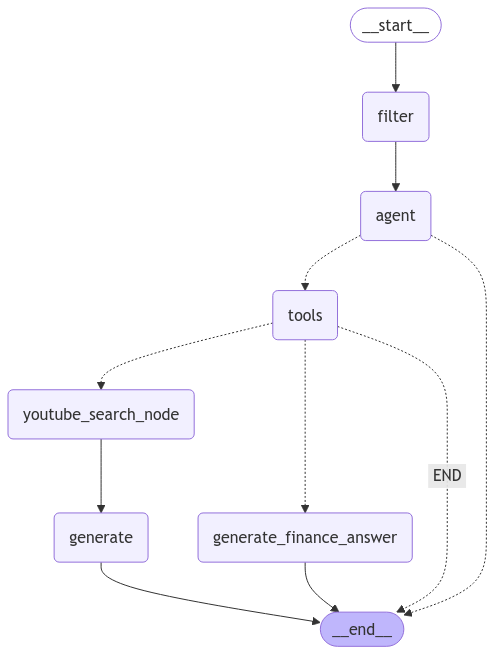

In [4]:
from app import get_langGraph_image_flow

get_langGraph_image_flow()

In [3]:
from pinecone_create import create_pinecone_index

create_pinecone_index()

In [1]:
from app import execute_workflow

{
    "message": "Hello how are you. Can you please tell me about the geeksVisor company",
    "user_id": "6724a7ae270a38bc33cbcf2e",
    "thread_id": "1"
}

print(execute_workflow("Hello how are you. Can you please tell me about the geeksVisor company", "6724a7ae270a38bc33cbcf2e", "1"))


e:\Projects_working\mathew\mathew_ENV_3.9.0\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Error during workflow execution: prepared statement "_pg3_1" already exists
{'error': 'prepared statement "_pg3_1" already exists'}


In [3]:
from chromadb_create import create_chromadb_index


create_chromadb_index()

In [4]:
from pymongo import MongoClient
from bson import ObjectId
import datetime
import os

# MongoDB connection URI
MONGO_URI = os.environ.get("MONGODB_URI")


# Connect to MongoDB
client = MongoClient(MONGO_URI)

# Access the 'test' database
db = client["mathew_data"]

# Access the 'transactions' collection
transactions_collection = db["transactions"]

query = {'date': datetime.datetime(2024, 10, 25, 0, 0), 'user': ObjectId('6724a7ae270a38bc33cbcf2e')}

# Execute the query
results = transactions_collection.find(query)

# Print the results
print("Query Results:")
for result in results:
    print(result)


Query Results:
{'_id': ObjectId('6772c7c31892ae515e4de8d8'), 'user': ObjectId('6724a7ae270a38bc33cbcf2e'), 'merchant': {'id': None, 'name': None}, 'date': datetime.datetime(2024, 10, 25, 0, 0), 'description': 'Interest Charge', 'entryType': 'DEBIT', 'amount': -14.85}
{'_id': ObjectId('6772c7c31892ae515e4de956'), 'user': ObjectId('6724a7ae270a38bc33cbcf2e'), 'merchant': {'id': None, 'name': None}, 'date': datetime.datetime(2024, 10, 25, 0, 0), 'description': 'Loan Payment', 'entryType': 'CREDIT', 'amount': 72.02}
{'_id': ObjectId('6772c7c31892ae515e4de92d'), 'user': ObjectId('6724a7ae270a38bc33cbcf2e'), 'merchant': {'id': 'mch_12y7t59uCjCmuzp8QSVLVz', 'name': 'El Vaquero'}, 'date': datetime.datetime(2024, 10, 25, 0, 0), 'description': 'El Vaquero', 'entryType': 'DEBIT', 'amount': -24.24}
{'_id': ObjectId('6772c7c31892ae515e4de92e'), 'user': ObjectId('6724a7ae270a38bc33cbcf2e'), 'merchant': {'id': None, 'name': None}, 'date': datetime.datetime(2024, 10, 25, 0, 0), 'description': 'Payment

In [1]:
import json

# Define the fields to keep for each transaction
fields_to_keep = ["user", "merchant", "date", "description", "entryType", "amount"]

# Input and output file paths
input_file = "database_data.json"  # Replace with your input file path
output_file = "filtered_transactions.json"  # Replace with your desired output file path

# Function to filter the transaction data
def filter_transactions(transactions):
    filtered_data = []
    for transaction in transactions:
        # Extract only the necessary fields
        filtered_transaction = {key: transaction[key] for key in fields_to_keep if key in transaction}
        filtered_data.append(filtered_transaction)
    return filtered_data

# Main script
try:
    with open(input_file, "r") as infile:
        data = json.load(infile)  # Load the entire JSON file

        # Ensure "transactions" collection exists
        if "transactions" in data:
            transactions = data["transactions"]
            filtered_transactions = filter_transactions(transactions)

            # Write filtered data to a new JSON file
            with open(output_file, "w") as outfile:
                json.dump(filtered_transactions, outfile, indent=4)

            print(f"Filtered transactions have been saved to {output_file}")
        else:
            print("The 'transactions' collection was not found in the JSON file.")

except Exception as e:
    print(f"An error occurred: {e}")

Filtered transactions have been saved to filtered_transactions.json


In [ ]:
import json
from pymongo import MongoClient

# MongoDB connection URI
MONGODB_URI = os.environ.get("MONGODB_URI")

# Database and collection names
DATABASE_NAME = "mathew_data"
COLLECTION_NAME = "transactions"

# Load the filtered JSON data
with open('filtered_transactions.json', 'r') as file:
    filtered_data = json.load(file)

# Connect to MongoDB
client = MongoClient(MONGODB_URI)
db = client[DATABASE_NAME]
collection = db[COLLECTION_NAME]

# Insert data into the collection
if isinstance(filtered_data, list):  # Check if the JSON is a list
    collection.insert_many(filtered_data)
    print(f"Data successfully inserted into {DATABASE_NAME}.{COLLECTION_NAME}!")
else:
    print("Expected a list of transactions in the JSON file.")

# Close the connection
client.close()


Data successfully inserted into mathew_data.transactions!


In [21]:
import json
from datetime import datetime
from pymongo import MongoClient
from bson import ObjectId
from dateutil import parser as date_parser
import os

# ----------------------------- Configuration -----------------------------

# MongoDB connection URI
MONGO_URI = os.environ.get("MONGODB_URI")  # Replace with your MongoDB URI

# Database and Collection Names
DATABASE_NAME = "mathew_data"          # Desired Database Name
COLLECTION_NAME = "transactions"       # Desired Collection Name

# Path to your JSON file
JSON_FILE_PATH = "filtered_transactions.json"   # Replace with your JSON file path

# ----------------------------- Helper Functions -----------------------------

def convert_document(doc):
    """
    Converts fields in the document to appropriate data types.
    
    - 'user': Converts from string to ObjectId.
    - 'date': Converts from string to datetime.
    - 'createdAt' & 'updatedAt': Converts from string to datetime if present.
    - 'bankAccountId', 'merchant.id', etc.: Converts from string to ObjectId if applicable.
    
    Args:
        doc (dict): The original document.

    Returns:
        dict: The transformed document with correct data types.
    """
    transformed_doc = doc.copy()  # Create a copy to avoid mutating the original

    # Convert 'user' from string to ObjectId
    if 'user' in transformed_doc and isinstance(transformed_doc['user'], str):
        try:
            transformed_doc['user'] = ObjectId(transformed_doc['user'])
        except Exception as e:
            print(f"Error converting 'user' to ObjectId: {e}")

    # Convert 'date' from string to datetime
    if 'date' in transformed_doc and isinstance(transformed_doc['date'], str):
        try:
            transformed_doc['date'] = date_parser.isoparse(transformed_doc['date'])
        except Exception as e:
            print(f"Error converting 'date' to datetime: {e}")

    # Convert 'createdAt' from string to datetime if present
    if 'createdAt' in transformed_doc and isinstance(transformed_doc['createdAt'], str):
        try:
            transformed_doc['createdAt'] = date_parser.isoparse(transformed_doc['createdAt'])
        except Exception as e:
            print(f"Error converting 'createdAt' to datetime: {e}")

    # Convert 'updatedAt' from string to datetime if present
    if 'updatedAt' in transformed_doc and isinstance(transformed_doc['updatedAt'], str):
        try:
            transformed_doc['updatedAt'] = date_parser.isoparse(transformed_doc['updatedAt'])
        except Exception as e:
            print(f"Error converting 'updatedAt' to datetime: {e}")

    # Convert 'bankAccountId' from string to ObjectId if present
    if 'bankAccountId' in transformed_doc and isinstance(transformed_doc['bankAccountId'], str):
        try:
            transformed_doc['bankAccountId'] = ObjectId(transformed_doc['bankAccountId'])
        except Exception as e:
            print(f"Error converting 'bankAccountId' to ObjectId: {e}")

    # Convert 'merchant.id' from string to ObjectId if present and not null
    if 'merchant' in transformed_doc and isinstance(transformed_doc['merchant'], dict):
        if 'id' in transformed_doc['merchant'] and isinstance(transformed_doc['merchant']['id'], str):
            try:
                transformed_doc['merchant']['id'] = ObjectId(transformed_doc['merchant']['id'])
            except Exception as e:
                print(f"Error converting 'merchant.id' to ObjectId: {e}")

    # Handle other potential ObjectId fields similarly
    # Add more conversions as needed based on your schema

    return transformed_doc

# ----------------------------- Main Execution -----------------------------

def recreate_database():
    """
    Recreates the MongoDB database with proper data types by:
    
    1. Connecting to MongoDB.
    2. Dropping the existing database or collection.
    3. Reading the JSON data.
    4. Transforming each document.
    5. Inserting the transformed documents into MongoDB.
    """
    # Step 1: Connect to MongoDB
    try:
        client = MongoClient(MONGO_URI)
        print("Connected to MongoDB successfully.")
    except Exception as e:
        print(f"Error connecting to MongoDB: {e}")
        return

    # Step 2: Drop the existing database (optional)
    # WARNING: This will delete all data in the database. Use with caution.
    try:
        client.drop_database(DATABASE_NAME)
        print(f"Dropped existing database: {DATABASE_NAME}")
    except Exception as e:
        print(f"Error dropping database: {e}")
        # If you prefer to drop only the collection, uncomment below
        # db = client[DATABASE_NAME]
        # db.drop_collection(COLLECTION_NAME)
        # print(f"Dropped collection: {COLLECTION_NAME}")
        return

    # Step 3: Create a new database and collection
    db = client[DATABASE_NAME]
    collection = db[COLLECTION_NAME]
    print(f"Created new database: {DATABASE_NAME}, collection: {COLLECTION_NAME}")

    # Step 4: Read the JSON data
    try:
        with open(JSON_FILE_PATH, 'r') as file:
            data = json.load(file)
            print(f"Loaded {len(data)} documents from {JSON_FILE_PATH}")
    except Exception as e:
        print(f"Error reading JSON file: {e}")
        return

    # Step 5: Transform and insert documents
    transformed_documents = []
    for idx, doc in enumerate(data):
        transformed_doc = convert_document(doc)
        transformed_documents.append(transformed_doc)
        print(f"Transformed document {idx+1}/{len(data)}")

    # Insert transformed documents into MongoDB
    try:
        if transformed_documents:
            result = collection.insert_many(transformed_documents)
            print(f"Inserted {len(result.inserted_ids)} documents into MongoDB.")
        else:
            print("No documents to insert.")
    except Exception as e:
        print(f"Error inserting documents into MongoDB: {e}")
    finally:
        # Step 6: Close the MongoDB connection
        client.close()
        print("Closed MongoDB connection.")


recreate_database()

Connected to MongoDB successfully.
Dropped existing database: mathew_data
Created new database: mathew_data, collection: transactions
Loaded 572 documents from filtered_transactions.json
Transformed document 1/572
Transformed document 2/572
Error converting 'merchant.id' to ObjectId: 'mch_12y7t59Rw4Yp5h6ZvLiTmR' is not a valid ObjectId, it must be a 12-byte input or a 24-character hex string
Transformed document 3/572
Transformed document 4/572
Error converting 'merchant.id' to ObjectId: 'mch_12y7t59Rw4Yp5h6ZvLiTmR' is not a valid ObjectId, it must be a 12-byte input or a 24-character hex string
Transformed document 5/572
Error converting 'merchant.id' to ObjectId: 'mch_12y7t59Rw4Yp5h6ZvLiTmR' is not a valid ObjectId, it must be a 12-byte input or a 24-character hex string
Transformed document 6/572
Transformed document 7/572
Transformed document 8/572
Transformed document 9/572
Transformed document 10/572
Error converting 'merchant.id' to ObjectId: 'mch_12y7t59Rw4Yp5h6ZvLiTmR' is not 

In [25]:
from langchain import hub 

prompt = hub.pull("rlm/rag-prompt")

print(prompt.messages[0].template)


AttributeError: 'HumanMessagePromptTemplate' object has no attribute 'template'

In [26]:
print(prompt)

input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


In [3]:
prompt.get(template)

AttributeError: 'ChatPromptTemplate' object has no attribute 'get'

In [2]:
# mongodb_create.py

import os
import time
import uuid
from dotenv import load_dotenv
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_mongodb.vectorstores import MongoDBAtlasVectorSearch
from mongodb_reuse import get_mongodb_vector_store, get_embedding_model
from pymongo import MongoClient
MONGODB_ATLAS_CLUSTER_URI = os.environ.get("MONGODB_ATLAS_CLUSTER_URI")

COLLECTION_NAME = "langchain_test_vectorstores"
DB_NAME = "langchain_test_db"

client = MongoClient(MONGODB_ATLAS_CLUSTER_URI)
    
MONGODB_COLLECTION = client[DB_NAME][COLLECTION_NAME]




# Load environment variables from .env file
load_dotenv()




try:
        emb_model = get_embedding_model()
        vector_search = MongoDBAtlasVectorSearch(
            embedding=emb_model,
            collection=MONGODB_COLLECTION,
            index_name="vector_index"  # Use a predefined index name
        )
        result = vector_search.similarity_search_with_relevance_scores("what is ledger iq", k=4)
        print(result)

except Exception as e:
        print(f"Error adding documents to the vector store: {e}")


[(Document(metadata={'_id': '2d932f7d-608f-4183-b125-f3142831ad4b', 'source': './book-keeping.pdf', 'page': 0}, page_content='1. What is Ledger IQ?\n \nLedger IQ is an AI-powered bookkeeping app designed to help small businesses analyze financial performance, send invoices, generate profit'), 0.047428011894226074), (Document(metadata={'_id': '70718a3e-2222-49ac-b3f6-a46c5ee94b1c', 'source': './book-keeping.pdf', 'page': 1}, page_content='12. Does Ledger IQ calculate taxes?\n \nCurrently, Ledger IQ focuses on bookkeeping and does not calculate taxes. However, if you choose our parent company, UnitedTax.AI, to handle'), 0.12143099308013916), (Document(metadata={'_id': '96eb286e-87a3-4ca2-ad79-d3f58be2d9d9', 'source': './book-keeping.pdf', 'page': 0}, page_content='2. How does Ledger IQ use AI?\n \nLedger IQ’s AI analyzes financial data, identifies trends, and provides actionable recommendations to improve your business’s financial health.'), 0.12272131443023682), (Document(metadata={'_id

In [1]:
from pinecone_reuse import get_pinecone_index

vector_store = get_pinecone_index()

print(vector_store)

e:\mathew\venv\lib\site-packages\pinecone\data\index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


NotFoundException: (404)
Reason: Not Found
HTTP response headers: HTTPHeaderDict({'content-type': 'text/plain; charset=utf-8', 'access-control-allow-origin': '*', 'vary': 'origin,access-control-request-method,access-control-request-headers', 'access-control-expose-headers': '*', 'x-pinecone-api-version': '2024-07', 'X-Cloud-Trace-Context': '4e66be7727ceff1d6584a35e6bf5a789', 'Date': 'Thu, 02 Jan 2025 13:52:55 GMT', 'Server': 'Google Frontend', 'Content-Length': '87', 'Via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000'})
HTTP response body: {"error":{"code":"NOT_FOUND","message":"Resource vector_index not found"},"status":404}


In [4]:
from pinecone import Pinecone, ServerlessSpec
print(Pinecone.list_indexes())

NameError: name 'self' is not defined

In [2]:
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
import pandas as pd
import json
import os

YOUTUBE_API_KEY = os.environ.get("YOUTUBE_API")
channel_id = "UC8butISFwT-Wl7EV0hUK0BQ" # freeCodeCamp # "UC_x5XG1OV2P6uZZ5FSM9Ttw" # Google Developers channel

def test_youtube_api():
    """Simple test for YouTube API functionality"""
    print("🔍 Testing YouTube API Connection...")
    
    try:
        # Initialize the YouTube API client
        youtube = build('youtube', 'v3', developerKey=YOUTUBE_API_KEY)
        print("✅ Successfully connected to YouTube API")
        
        # Try a simple search
        print("\n📌 Performing test search...")
        search_request = youtube.search().list(
            part="snippet",
            q="javaScript toturial",
            type="video",
            channelId=channel_id,
            maxResults=3
        )
        
        # Execute the search
        search_response = search_request.execute()
        print("----------------------- raw results ----------------------------")
        print(search_response)
        # Process results
        videos = []
        for item in search_response.get('items', []):
            videos.append({
                'title': item['snippet']['title'],
                'channel': item['snippet']['channelTitle'],
                "description": item['snippet']['description'],
                'url': f"https://www.youtube.com/watch?v={item['id']['videoId']}"
            })
        
        # Display results
        if videos:
            print("\n✅ Search successful! Here are the results:")
            df = pd.DataFrame(videos)
            display(df)
        else:
            print("❌ No videos found")
            
    except HttpError as e:
        error_details = json.loads(e.content)
        print(f"\n❌ HTTP Error occurred:")
        print(f"Status Code: {e.resp.status}")
        print(f"Error Message: {error_details['error']['message']}")
    except Exception as e:
        print(f"\n❌ An error occurred: {str(e)}")

# Run the test
test_youtube_api()

🔍 Testing YouTube API Connection...
✅ Successfully connected to YouTube API

📌 Performing test search...
----------------------- raw results ----------------------------
{'kind': 'youtube#searchListResponse', 'etag': 'OJ3R7KhsUX2-YVYvM_gpUfwIndA', 'nextPageToken': 'CAMQAA', 'regionCode': 'PK', 'pageInfo': {'totalResults': 233730, 'resultsPerPage': 3}, 'items': [{'kind': 'youtube#searchResult', 'etag': 'bwnuWZmLH2nClVeQmWJorr8V1Dg', 'id': {'kind': 'youtube#video', 'videoId': 'PkZNo7MFNFg'}, 'snippet': {'publishedAt': '2018-12-10T14:13:40Z', 'channelId': 'UC8butISFwT-Wl7EV0hUK0BQ', 'title': 'Learn JavaScript - Full Course for Beginners', 'description': 'This complete 134-part JavaScript tutorial for beginners will teach you everything you need to know to get started with the ...', 'thumbnails': {'default': {'url': 'https://i.ytimg.com/vi/PkZNo7MFNFg/default.jpg', 'width': 120, 'height': 90}, 'medium': {'url': 'https://i.ytimg.com/vi/PkZNo7MFNFg/mqdefault.jpg', 'width': 320, 'height': 180

,title,channel,description,url
0,Learn JavaScript - Full Course for Beginners,freeCodeCamp.org,This complete 134-part JavaScript tutorial for...,https://www.youtube.com/watch?v=PkZNo7MFNFg
1,JavaScript Programming - Full Course,freeCodeCamp.org,Learn JavaScript from scratch by solving over ...,https://www.youtube.com/watch?v=jS4aFq5-91M
2,JavaScript DOM Manipulation – Full Course for ...,freeCodeCamp.org,Learn about JavaScript DOM manipulation in thi...,https://www.youtube.com/watch?v=5fb2aPlgoys


In [2]:
from All_Nodes_and_Agent import search_youtube_videos
import pandas as pd
results = search_youtube_videos("python toturial")
print(results)
df = pd.DataFrame(results)
display(df)

{'kind': 'youtube#searchListResponse', 'etag': '_uT1DrmLvWIWJe3S4lAg_Zqc75Q', 'nextPageToken': 'CAMQAA', 'regionCode': 'PK', 'pageInfo': {'totalResults': 1000000, 'resultsPerPage': 3}, 'items': [{'kind': 'youtube#searchResult', 'etag': 'oHxEx9frXAe5WvXt0OR9PvpqDpI', 'id': {'kind': 'youtube#video', 'videoId': 'kqtD5dpn9C8'}, 'snippet': {'publishedAt': '2020-09-16T13:00:20Z', 'channelId': 'UCWv7vMbMWH4-V0ZXdmDpPBA', 'title': 'Python for Beginners - Learn Coding with Python in 1 Hour', 'description': 'Learn Python basics in just 1 hour! Perfect for beginners interested in AI and coding. ⚡ Plus, get 6 months of PyCharm FREE with ...', 'thumbnails': {'default': {'url': 'https://i.ytimg.com/vi/kqtD5dpn9C8/default.jpg', 'width': 120, 'height': 90}, 'medium': {'url': 'https://i.ytimg.com/vi/kqtD5dpn9C8/mqdefault.jpg', 'width': 320, 'height': 180}, 'high': {'url': 'https://i.ytimg.com/vi/kqtD5dpn9C8/hqdefault.jpg', 'width': 480, 'height': 360}}, 'channelTitle': 'Programming with Mosh', 'liveBro

ValueError: Mixing dicts with non-Series may lead to ambiguous ordering.